In [1]:
# Import the importatnt libraries
import os
import numpy as np
from torchvision import models
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split, Dataset
import matplotlib.pyplot as plt
from torchvision import transforms
import pandas as pd
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import f1_score
import copy

In [2]:
# ignoring the warning messages
import warnings
from IPython.display import display
warnings.filterwarnings('ignore')


In [3]:
torch.manual_seed(42)
# batch size for all the future processes
batch_size = 16

In [4]:
# custom dataloader for the test dataset
class TestImageDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.folder_path, img_name)
        image = Image.open(img_path).convert("RGB")  # Ensure RGB format
        if self.transform:
            image = self.transform(image)
        return image, img_name  # Return image and file name for reference

In [5]:
# transformations for the training datasets
train_transforms = transforms.Compose([
    transforms.Resize((384,384)), # resize the image according to the input size of the model
    # transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.3), # flip the image horizontally with probality of 0.3
    transforms.RandomVerticalFlip(p=0.3), # flip the image vertically with probality of 0.3
    transforms.CenterCrop(384), # crop the image from the center
    transforms.RandomRotation(degrees=(-12, 12)),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.35, contrast=0.35, saturation=0.35, hue=0.2)], p=0.3), # apply random color jitter with probality of 0.3
    transforms.RandomApply([transforms.RandomAffine(degrees=15, translate=(0.15, 0.15), scale=(0.85, 1.15))], p=0.4), # apply random affine transformation with probality of 0.4
    transforms.RandomApply(([transforms.GaussianBlur(kernel_size=3)]), p=0.3), # apply random gaussian blur with probality of 0.3 #Change the kernel size according to the model not max 5
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.1), ratio=(0.3, 3.3)), # apply random erasing with probality of 0.3
    transforms.ToTensor(), # # Converts image to tensor and rescales to [0.0, 1.0]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # normalize the image

])

In [6]:
# transfromations for the test and validation datasets
test_val_transforms = transforms.Compose([
    transforms.Resize((480,480)), # resize the image according to the input size of the model
    # transforms.Resize((224,224)),
    transforms.CenterCrop(480),
    transforms.ToTensor(), # convert the image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # normalize the image
])

In [7]:
# load the training dataset
train_directory = '/kaggle/input/deep-learning-practice-image-classification/train'
original_dataset = ImageFolder(train_directory) #Loading it without transformations

In [8]:
# Loading the test dataset
test_directory = '/kaggle/input/deep-learning-practice-image-classification/test'
test_dataset = TestImageDataset(test_directory, transform=test_val_transforms)

In [9]:
# split the original dataset into training and validation datasets
train_size = int(0.85 * len(original_dataset))
val_size = len(original_dataset) - train_size
train_dataset, val_dataset = random_split(original_dataset, [train_size, val_size])

In [10]:
# apply the transformations to the training
train_dataset.dataset.transform = train_transforms 
val_dataset.dataset.transform = test_val_transforms

In [11]:
# Data loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
# Validation loader
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=8)

In [12]:
# aplly the Data loader to the test dataset
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

In [13]:
def inverse_normalize(image, mean, std):
    for i in range(image.shape[0]):
        image[i] = image[i]*std[i] + mean[i]
    return image.clamp(0, 1) # Ensure values are withing 0 and 1

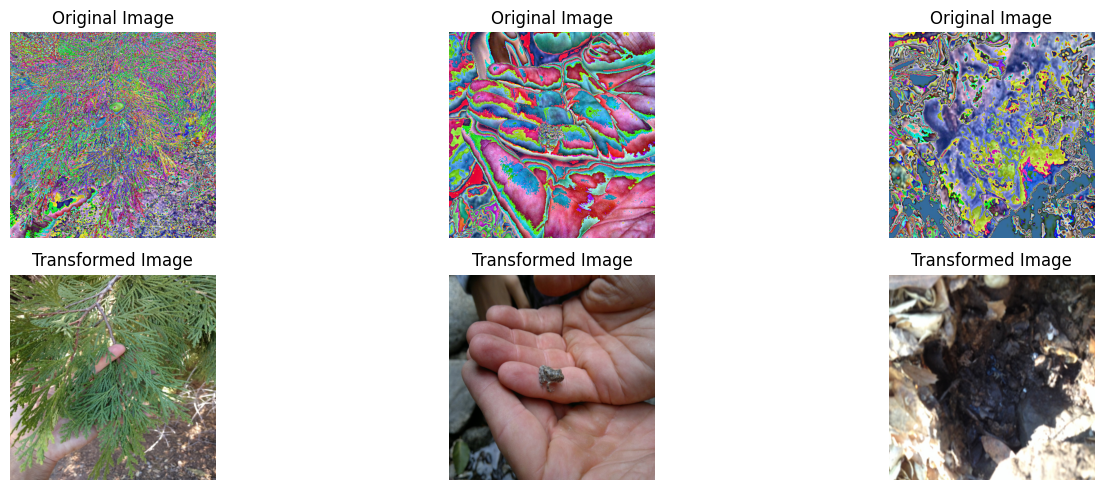

In [14]:
from torchvision.transforms.functional import to_pil_image
# plot the first three images of the training dataset
fig, ax = plt.subplots(2, 3, figsize=(15, 5))
for i in range(3):
    original_image = train_dataset[i][0]
    ax[0,i].imshow(to_pil_image(original_image))
    ax[0,i].axis('off')
    ax[0,i].set_title('Original Image')

    # transformed_image = train_dataset[i][0]
    transformed_image = inverse_normalize(original_image
, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ax[1, i].imshow(transformed_image.permute(1, 2, 0))
    ax[1, i].axis('off')
    ax[1, i].set_title('Transformed Image')
plt.tight_layout()
plt.show()

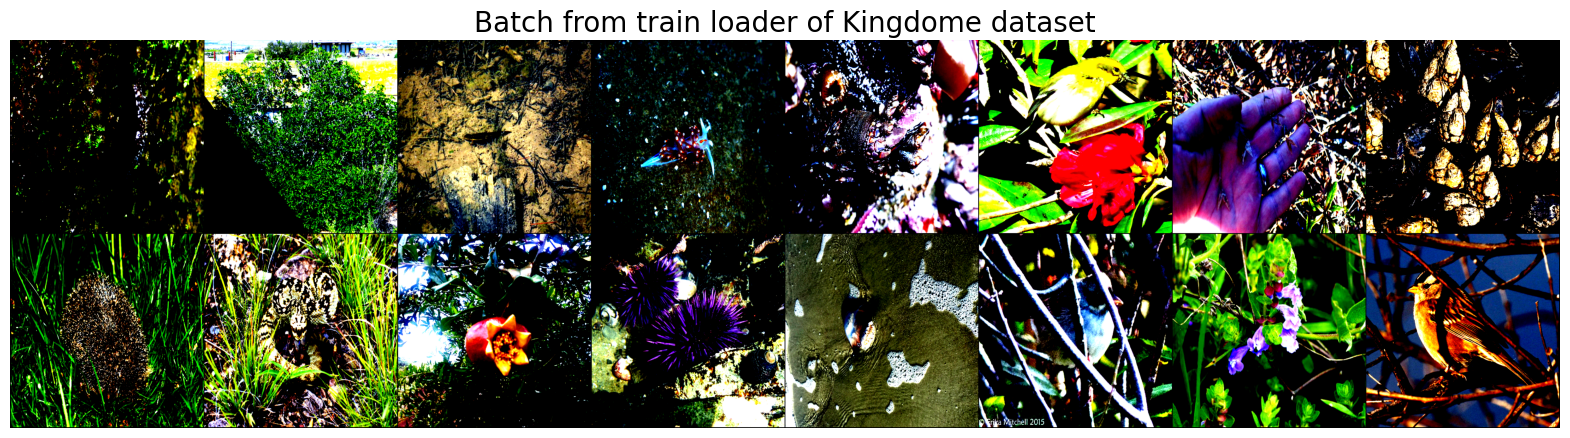

In [15]:
import torchvision.utils as utils
# plot the first batch of images of train_loader on a grid fromat
images, labels = next(iter(train_loader))
grid = utils.make_grid(images, nrow=8)
plt.figure(figsize=(20, 20))
plt.imshow(grid.permute(1, 2, 0))
plt.title('Batch from train loader of Kingdome dataset', fontsize=20)
plt.axis('off')
plt.show()

In [16]:
# print all the info of the datasets like length classes etc
print('original dataset:', original_dataset)
print("-"*100)
print('Classes:', original_dataset.classes)
print("-"*100)
print('Batches of Train dataset:', len(train_dataset))
print("-"*100)
print('Batches of Validation dataset:', len(val_dataset))
print("-"*100)
print('Lenght of Test dataset:', len(test_dataset))
print("-"*100)
print('Batches of Test dataset:', len(test_loader))
print("-"*100)
print('Class to idx:', original_dataset.class_to_idx)
print("-"*100)


original dataset: Dataset ImageFolder
    Number of datapoints: 9999
    Root location: /kaggle/input/deep-learning-practice-image-classification/train
----------------------------------------------------------------------------------------------------
Classes: ['Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi', 'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia']
----------------------------------------------------------------------------------------------------
Batches of Train dataset: 8499
----------------------------------------------------------------------------------------------------
Batches of Validation dataset: 1500
----------------------------------------------------------------------------------------------------
Lenght of Test dataset: 2000
----------------------------------------------------------------------------------------------------
Batches of Test dataset: 125
------------------------------------------------------------------------------------------------

In [17]:
# define a function for training the model on the only for training dataset 
def train(model, train_loader, val_loader, criterion, optimizer, device, epoch, num_epochs, scheduler):
    # set the model to training mode
    model.train()
    # initialize the running loss, number of correct predictions and total number of predictions
    running_loss = 0.0
    num_correct_preds = 0.0
    total_preds = 0.0
    train_preds = []
    train_labels = []

    # iterate over the training dataset and show the progress bar
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as tepoch:
        for images, labels in train_loader:
            # move the images and labels to the device
            images, labels = images.to(device), labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward pass
            outputs = model(images)
            # calculate the loss
            loss = criterion(outputs, labels)
            # backward pass
            loss.backward()
            # optimize the weights
            optimizer.step()
            # calculate the running loss and update the running loss
            running_loss += loss.item()
            # get the predicted labels
            _, preds = torch.max(outputs, 1)
            # update the total number of predictions
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

            # update the number of correct predictions
            num_correct_preds += (preds == labels).sum().item()
            total_preds += labels.size(0)

            # update the progress bar
            tepoch.set_postfix(loss=running_loss/(tepoch.n+1), accuracy=f"{(num_correct_preds / len(train_loader.dataset)) * 100:.2f}%")

            tepoch.update(1) # increment the progress bar by 1
    # add the sheduler step
    scheduler.step()
    # calculate the f1 score and traingin accuracy
    f1 = f1_score(train_labels, train_preds, average='weighted')
    train_accuracy = (num_correct_preds / total_preds)*100

    # return the training accuracy, running loss and f1 score
    return train_accuracy, running_loss/len(train_loader), f1
    

In [18]:
# define the function for validating the model on the validation dataset
def validate(model, val_loader, criterion, device):
    # set the model to evaluation mode
    model.eval()
    # initialize the running loss, number of correct predictions and total number of predictions
    running_loss = 0.0
    num_correct_preds = 0.0
    total_preds = 0.0
    val_preds = []
    val_labels = []

    # No need to iterate over the validation dataset for progressbar
    with torch.no_grad():
        for images, labels in val_loader:
            # move the images and labels to the device
            images, labels = images.to(device), labels.to(device)
            # forward pass
            outputs = model(images)
            # calculate the loss
            loss = criterion(outputs, labels)
            # calculate the running loss and update the running loss
            running_loss += loss.item()
            # get the predicted labels
            _, preds = torch.max(outputs, 1)
            # update the total number of predictions
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
            # update the number of correct predictions
            num_correct_preds += (preds == labels).sum().item()
            total_preds += labels.size(0)

    # calculate the f1 score and validation accuracy
    f1 = f1_score(val_labels, val_preds, average='weighted')
    val_accuracy = (num_correct_preds / total_preds)*100
    
    return val_accuracy, running_loss/len(val_loader), f1

In [19]:
# training the model on the training dataset and validating it on the validation dataset
def training_model(model, train_loader, val_loader,criterion, optimizer, num_epochs, device, scheduler, model_name):
    best_accuracy = 0.0
    best_model = None
    for epoch in range(num_epochs):
        # train the model
        train_accuracy, train_loss, train_f1 = train(model, train_loader, val_loader, criterion, optimizer, device, epoch, num_epochs, scheduler)
        # print the training accuracy and train_loss, train_f1
        # print(f'Epoch {epoch+1}/{num_epochs}, Train Accuracy: {train_accuracy:.2f}%, Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}')

        # validate the model
        val_accuracy, val_loss, val_f1 = validate(model, val_loader, criterion, device)
        # print the validation accuracy and val_loss, val_f1
        # print(f'Epoch {epoch+1}/{num_epochs}, Val Accuracy: {val_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}')

        # save the best model
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), f'best_model_{model_name}_{epoch+1}.pth')
            best_model = copy.deepcopy(model.state_dict())
            
        # print the training and validation accuracy and loss
            print(f'Best model saved at epoch {epoch+1}/{num_epochs} with,\n Training Accuracy: {train_accuracy:.2f}%, Training Loss: {train_loss:.4f}, Training f1 score: {train_f1:.4f},\n Validation Accuracy: {val_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation f1 score: {val_f1:.4f}')
        
        torch.cuda.empty_cache()
    return model, best_model

In [20]:
# using the pre-trained model with importing the pretrained weight efficente_v2_m
from torchvision.models import EfficientNet_V2_M_Weights
model = models.efficientnet_v2_m(weights=EfficientNet_V2_M_Weights.DEFAULT)

# Try on different m

Downloading: "https://download.pytorch.org/models/efficientnet_v2_m-dc08266a.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_m-dc08266a.pth
100%|██████████| 208M/208M [00:00<00:00, 229MB/s] 


In [21]:
# fine tuning the last classifier layer wiht out_features = 10
num_classes = 10 #number of outfeatures
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 10)

In [22]:
# shift the model to the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = nn.DataParallel(model, device_ids=[0, 1])  # Use GPUs 0 and 1
model = model.to(device)

In [23]:
# num_epochs = 15
num_epochs = 5
criterion = nn.CrossEntropyLoss()
# optimizer = optim.NAdam(model.parameters(), lr=1e-4)
# use the optimizer wiht SGD, momentum  and nestrov momentum
# optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, nesterov=True)
optimizer = optim.NAdam(model.parameters(), lr=1e-4)

# scheduler for the learning rate
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0.1e-6)
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

last_epoch_model, best_model = training_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, scheduler,'efficientnet_v2_m')

Epoch 1/5: 100%|██████████| 532/532 [07:38<00:00,  1.16batch/s, accuracy=81.70%, loss=0.625]


Best model saved at epoch 1/5 with,
 Training Accuracy: 81.70%, Training Loss: 0.6250, Training f1 score: 0.8172,
 Validation Accuracy: 90.73%, Validation Loss: 0.3254, Validation f1 score: 0.9081


Epoch 2/5: 100%|██████████| 532/532 [07:57<00:00,  1.11batch/s, accuracy=93.63%, loss=0.225]


Best model saved at epoch 2/5 with,
 Training Accuracy: 93.63%, Training Loss: 0.2247, Training f1 score: 0.9364,
 Validation Accuracy: 91.47%, Validation Loss: 0.2867, Validation f1 score: 0.9150


Epoch 3/5: 100%|██████████| 532/532 [08:00<00:00,  1.11batch/s, accuracy=97.15%, loss=0.099] 


Best model saved at epoch 3/5 with,
 Training Accuracy: 97.15%, Training Loss: 0.0990, Training f1 score: 0.9715,
 Validation Accuracy: 92.33%, Validation Loss: 0.3534, Validation f1 score: 0.9241


Epoch 4/5: 100%|██████████| 532/532 [07:59<00:00,  1.11batch/s, accuracy=98.71%, loss=0.0474]


Best model saved at epoch 4/5 with,
 Training Accuracy: 98.71%, Training Loss: 0.0474, Training f1 score: 0.9871,
 Validation Accuracy: 93.40%, Validation Loss: 0.2797, Validation f1 score: 0.9340


Epoch 5/5: 100%|██████████| 532/532 [08:01<00:00,  1.11batch/s, accuracy=99.44%, loss=0.021] 


Best model saved at epoch 5/5 with,
 Training Accuracy: 99.44%, Training Loss: 0.0210, Training f1 score: 0.9944,
 Validation Accuracy: 93.60%, Validation Loss: 0.2888, Validation f1 score: 0.9361


In [24]:
# Evaluate the model on the test dataset
def evaluate(new_model, test_loader, device):
    # set the model to evaluation
    new_model.eval()
    # initialize list of predictions
    predictions = []
    # iterate over the test dataset
    with torch.no_grad():
        for images, names in test_loader:
            # move the images to the device
            images = images.to(device)
            # forward pass
            outputs = new_model(images)
            # get the predicted labels
            _, preds = torch.max(outputs, 1)
            # store the image names and predicted labels without the extension
            for name, pred in zip(names, preds):
                predictions.append((name.split('.')[0], pred.item()))
    # return the predictions
    return predictions

In [25]:
# model.load_state_dict(torch.load('/kaggle/working/best_model_efficientnet_v2_m_5.pth'))
# model.to(device)

In [26]:
# model.load_state_dict(best_model)

In [27]:
# prediction using the best loaded model
# predictions = evaluate(model, test_loader, device)

In [32]:
# # prediction using the best loaded model
predictions = evaluate(last_epoch_model, test_loader,device)

In [29]:
# # prediction using without loading the model
# predictions = evaluate(best_model, test_loader, device)

In [33]:
# creating the submission file for the test dataset
submission = pd.DataFrame(predictions, columns=['Image_ID', 'Label'])
submission.to_csv('NAdam_model_model_5_93.6.csv', index=False)
print(f"Submission file created successfully")

Submission file created successfully


In [34]:
print(submission.head(5))

     Image_ID  Label
0  Image_0612      5
1  Image_0946      4
2  Image_0755      8
3  Image_0178      2
4  Image_1593      5
